GROUP 10:
- Anna Costa: Assignment 3
- Federico Pilotto: Assignment 1 and final organization of the jupiter notebook
- Edoardo Caporin: Data Preparation and assignment 2

# Analysis of Vodafone users' fluxes

The study of the flux of people inside urban areas is of paramount importance to achieve an optimal understanding of emerging critical issues in the local mobility, and to explore areas of potential improvements in the infrastructures and local transports.

The mobility of users within and toward Padova has been monitored using the data provided by the Vodafone mobile carrier, which provides the information based on the users' connections to the network cells.
The data provided by the carrier encompasses the monitoring of the users connected to the Vodafone network in Padova in a four-month period from February to May of 2018.

To provide statistical insights on the number and the flow of users, the data is aggregated based on the origin and movements of the users by averaging the number of connections during the time of the monitoring.

To further avoid privacy violation issues, all observations with less than 30 units (e.g. day-areas for which $<$30 users have contributed) have been discarded and/or merged into dedicated categories (indicated with "altro", or "other").


## Datasets 

The data is provided in `.csv` files.

* __day_od.csv__: table of the origins and destinations of the users averaged by the day of the week. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).
* __distinct_users_day.csv__: table of the number of distinct users by origin. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).

The information is stored in the fields according to the following scheme: 

- __MONTH__: month analyzed
- __DOW__: day analyzed
- __ORIGIN__: users' origin area (do not consider this field)
- __DESTINATION__: users' destination area (do not consider this field)
- __CUST_CLASS__: user type (resident / Italian visitor / foreigner visitor)
- __COD_COUNTRY__: users' country code (e.g. 222=Italy)
- __COD_PRO__: users' province code (e.g. 12=Varese) 
- __PRO_COM__: users' comune code (e.g. 12026=Busto Arsizio)
- __FLOW__: number of movements for given date-time (with a minimum of 30 users)
- __VISITORS__: overall number of users 

Together with the data files, three lookup-tables are provided to allow matching the Italian institute of STATistics (ISTAT) country, province and comune codes to the actual names.

* __codici_istat_comune.csv__: lookup file containing the mapping between _comune_ ISTAT code-names
* __codici_istat_provincia.csv__: lookup file containing the mapping between _province_ ISTAT code-names
* __codici_nazioni.csv__: lookup file containing mapping the _country_ code to its name

Additional information, useful for the study of the flow of users, as the number of inhabitants of each province and the distance between Padova and all other Italian provinces can be extracted based on the data collected by the ISTAT:

   - English: https://www.istat.it/en/analysis-and-products/databases, Italian: https://www.istat.it/it/dati-analisi-e-prodotti/banche-dati
   
   - English/Italian: https://www.istat.it/en/archive/157423, Italian: https://www.istat.it/it/archivio/157423
   
   - `.zip` package containing the distances between comuni in Veneto region: http://www.istat.it/storage/cartografia/matrici_distanze/Veneto.zip

If deemed useful, the open repository [https://github.com/openpolis/geojson-italy](https://github.com/openpolis/geojson-italy) contains a `.json` file with the geographical coordinates of the provences and comuni of Italy.


## Assignments

1. Data preparation: the csv files are originated from different sources, hence resulting in differences in the encoding and end-of-lines that have to be taken into account in the data preparation phase. Make sure each .csv file is properly interpreted.

   1.1 Ranking of visitors from foreign countries: based on the number of total visitors per each country, create a ranked plot of the first 20 countries with the most visitors
   
   1.2 Ranking of Italian visitors by province, weighted by the number of inhabitants: based on the number of total visitors per Italian province, create a ranked plot of the first 20 provinces with the most visitors taking into account the number of inhabitants.


2. Study of the visitors' fluxes: you are asked to provide indications on how to invest resources to improve the mobility towards Padova. Consider the three main directions of visitors and commuters getting to Padova through the main highways (from south, A13 towards Bologna-Roma; from west, A4 towards Milano-Torino; from north-east, A4 towards Venice-Trieste). Evaluate which of the three directions has to be prioritized.

   2.1 Consider a simplified case involving only the mid-range mobility, based on the number of visitors/commuters from the nearby regions only
   
   2.2 Consider the provinces located on the three directions that are mostly contributing to the flow of weekend visitors and working daily commuters by performing a more detailed study of the fluxes based on the day of the week. Use the data available to provide what you believe is the best possible answer.


3. Plot the distribution of the number of visitors by the distance of the province of origin. Determine which kind of function should be used to describe the distribution.

   3.1 Assuming an analytic form can be used to describe the trend, create a regression or a fit to estimate the expected number of visitors by the distance of the province of origin and the corresponding uncertainties. Illustrate the difference between the resulting regression with respect to the numbers provided by the Vodafone monitoring, and highlight the five most striking discrepancies from the expectations.

# Imports

In [1]:
# Imports cell
import io                       # Used to write the CSV ISO-8859-1
import pandas as pd             # Used to store data into dataframes
import numpy as np              # Used to rename the column of dataframes
import matplotlib.pyplot as plt # Used to represent data
import chardet                  # Used to detect the encoding of the CSV files
import codecs                   # Used to read the CSV UTF-16
import seaborn as sns           # Used to represent data
# imports for the predictive assignment
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Data Paths

In [2]:
# List of csv files
filename_codici_istat_comuni = "data/codici_istat_comune.csv"
filename_codici_istat_provincia = "data/codici_istat_provincia.csv"
filename_codici_nazioni = "data/codici_nazioni.csv"
filename_day_od = "data/day_od.csv"
filename_distinct_user_day = "data/distinct_users_day.csv"
filename_distance_to_pd = "data/R05_PD.csv"
filename_distance_to_pd_txt = "data/R05_PD.txt"

# Creating a list to boost performances of the loops
filenames = [filename_codici_istat_comuni, filename_codici_istat_provincia, filename_codici_nazioni,
             filename_day_od, filename_distinct_user_day, filename_distance_to_pd]

# 1. Data Preparation
With the following function we are able to check the codification of each csv file and in case converting it into ISO-8859-1
in order to open all of them with the same encoding methods -> latin1

---
The function `check_encoding` is responsible for detecting the encoding of each CSV file.
- *param* `file`: The file path of the CSV file to be analyzed.

In [3]:
def check_encoding(file):
    #Read the file
    with open(file, 'rb') as f:
        #Detect the encoding
        result = chardet.detect(f.read())

    #Return a list of the encodings
    return result['encoding']

---
The function `encoding_converter` is responsible for converting each CSV file that has an encoding different to ISO-8859-1.
- *param* `files`: The list of the file paths

In [4]:
# Function which 
def encoding_converter(files):
    for file in files:
        # Saving the encoding of each file
        encodings = check_encoding(file)

        # If the encoding is different to ISO-8859-1 it has to be converted
        if encodings == 'ascii' :
            # Open the file and saving the content
            with codecs.open(file, 'r', 'ascii') as f:
                data = f.read()

            # Overwrite the file with a new encoding
            with io.open(file, 'w', encoding='utf-8') as f:
                f.write(data)

        if encodings == 'utf-16':
            # Open the file and saving the content
            with codecs.open(file, 'r', 'utf-16') as f:
                data = f.read()

            # Overwrite the file with a new encoding
            with io.open(file, 'w', encoding='latin1') as f:
                f.write(data)

### 1.1 Ranking of visitors from foreign countries
The idea behind this point is to groupby the columns of the countries codes and sum the number of visitors.
In this way we have the corresponding amount of foreign visitors for each county. With a simple descending sort, it's possible to select the 20 countries with most visitors

In [5]:
# Read the data from the csv file
df = pd.read_csv(filename_distinct_user_day, encoding='latin1', index_col=False)
df

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS
0,Mercoledì,visitor,222.0,35.0,35033.0,968
1,Lunedì,visitor,222.0,22.0,22098.0,64
2,Domenica,visitor,222.0,52.0,52032.0,516
3,Giovedì,visitor,222.0,108.0,108009.0,128
4,Giovedì,visitor,222.0,29.0,29048.0,512
...,...,...,...,...,...,...
12840,Mercoledì,foreigner,259.0,NaN,NaN,176
12841,Sabato,foreigner,602.0,NaN,NaN,164
12842,Giovedì,foreigner,732.0,NaN,NaN,80
12843,Giovedì,foreigner,297.0,NaN,NaN,80


In [6]:
# This function returns a list with the correspondace code_country/province - name
# type = 0 -> cod_country
# type = 1 -> cod_pro

def parsing(codes, type): 
    names = []
    if type == 0:
        data = pd.read_csv(filename_codici_nazioni, encoding='latin1', index_col=False)
        for i in codes:
            temp = data.loc[data['COD_COUNTRY'] == i, 'COUNTRY_NAME_IT'].iloc[0]
            names.append(str(temp))

    if  type == 1:
        data = pd.read_csv(filename_codici_istat_provincia, encoding='latin1', index_col=False)

        for i in codes:
            temp = data.loc[data['COD_PRO'] == i, 'PROVINCIA'].iloc[0]
            names.append(str(temp))
    
    return names


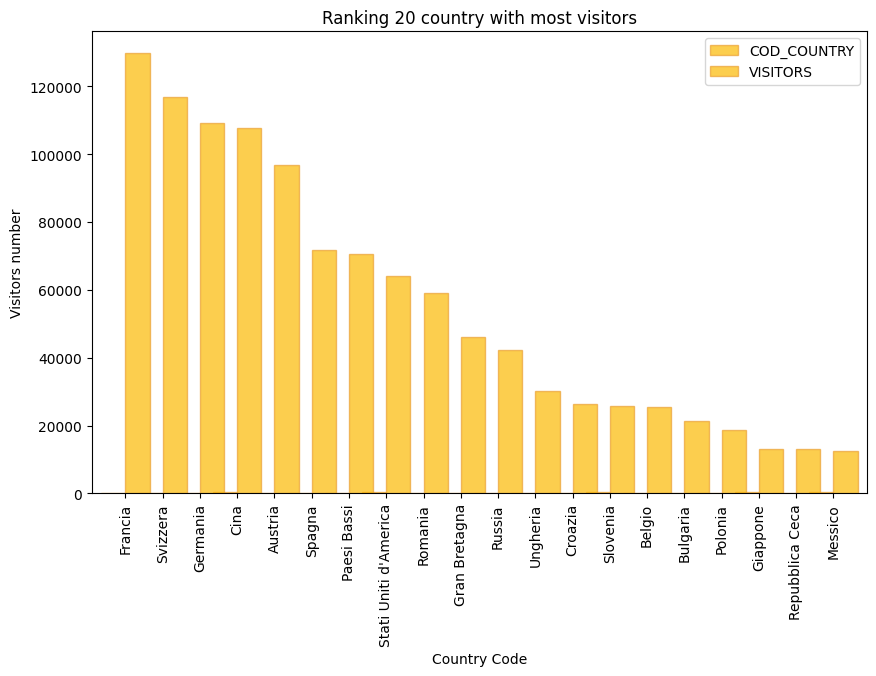

In [7]:
# Taking only the database with foreign visitors
df_foreign = df[df.CUST_CLASS.str.contains('foreigner')]

# Now grouping by the code of the country
# And sum the number of visitors
df_foreign = df_foreign.groupby('COD_COUNTRY')[['VISITORS']].sum().reset_index()

# To plot the 20 countries with the most number of visitors
# We need to sort the values and then take the first 20 positions
df_foreign.sort_values(by='VISITORS', inplace=True, ascending=False)
df_foreign = df_foreign.head(20)

# Parsing the codes country into thier names
codes = np.array(df_foreign['COD_COUNTRY'])
names = parsing(codes, 0)

# Plot the histogram
ax = df_foreign.plot(kind='bar', figsize=(10,6), width=1.3, align='center',color="#fcba03", alpha=0.7, ec='#eba134')
ax.set_title('Ranking 20 country with most visitors')
ax.set_xlabel('Country Code')
ax.set_ylabel('Visitors number')
ax.set_xticklabels(names)
plt.show()

### 1.2 Ranking of Italian visitors by province
This point is close to the previous one, but in this case we select only the rows of the DataFrame with the Italy code.
After that we can compute the groupby on the provinces code and sorting, as before, the values to get the ranking

In [8]:
# The italian code is 222, so we are going to take only the rows with the code 222 in COD_COUNTRY
df_italy = df.loc[df['COD_COUNTRY'] == 222]
df_italy

,DOW,CUST_CLASS,COD_COUNTRY,COD_PRO,PRO_COM,VISITORS
0,Mercoledì,visitor,222.0,35.0,35033.0,968
1,Lunedì,visitor,222.0,22.0,22098.0,64
2,Domenica,visitor,222.0,52.0,52032.0,516
3,Giovedì,visitor,222.0,108.0,108009.0,128
4,Giovedì,visitor,222.0,29.0,29048.0,512
...,...,...,...,...,...,...
12828,Martedì,visitor,222.0,65.0,65052.0,36
12829,Giovedì,visitor,222.0,22.0,22017.0,40
12830,Martedì,visitor,222.0,16.0,16053.0,36
12831,Venerdì,visitor,222.0,78.0,78031.0,36


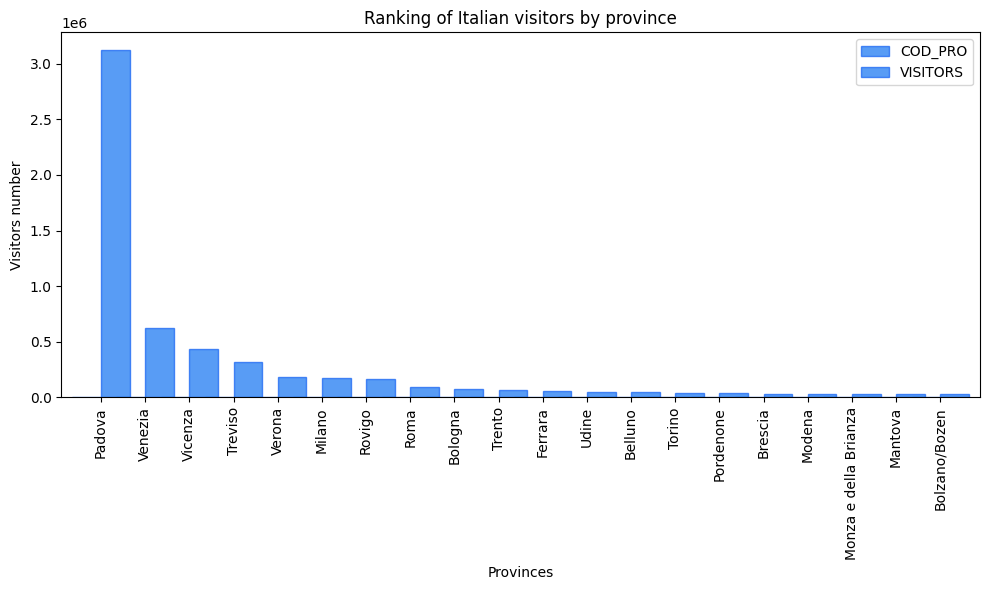

In [9]:
# Group by the code of the province
# And sum the number of visitors
df_italy = df_italy.groupby(['COD_PRO'])[['VISITORS']].sum().reset_index()

# Sort in descending mode the values, in order to take the 20 province with the most visitors
df_italy.sort_values(by='VISITORS', inplace= True, ascending=False)
df_italy = df_italy.head(20)

# Parsing the codes province into thier names
codes = np.array(df_italy['COD_PRO'])
visitors = np.array(df_italy['VISITORS'])
names = parsing(codes, 1)

# Plot the histogram
ax = df_italy.plot(kind='bar', figsize=(10,6), width=1.3, align='center', color="#1173f2", alpha=0.7, ec='#1160f2')
ax.set_alpha(0.8)
ax.set_title('Ranking of Italian visitors by province')
ax.set_xlabel('Provinces')
ax.set_ylabel('Visitors number')
ax.set_xticklabels(names)
plt.tight_layout()
plt.show()



# 2. Study of the visitors' fluxes

We need to check the flux from all the toll booth of the 3 highways passing through Padova.
We are going to operate dividing the area around Padova in 4 zones:
1. Padova Est -> A4 Torino - Milano
2. Padova Ovest -> A4 Venezia - Trieste
3. Padova Sud -> A13 Padova - Bologna
4. Padova Sud -> A1 Roma - Bologna which became A13 Bologna - Padova (so people coming from the centre of Italy)

---
The function `add_region` is responsible for mapping every code_reg (ISTAT code for the regions) with the name of the region
- *param* `data`: the dataframe with the cod_regs to be mapped

In [10]:
# This functions map all the regions
def add_region(data):
    regioni = {
        'Abruzzo': 13,
        'Basilicata': 17,
        'Calabria': 18,
        'Campania': 15,
        'Emilia Romagna': 8,
        'Friuli-Venezia Giulia': 6,
        'Lazio': 12,
        'Liguria': 7,
        'Lombardia': 3,
        'Marche': 11,
        'Molise': 14,
        'Piemonte': 1,
        'Puglia': 16,
        'Sardegna': 20,
        'Sicilia': 19,
        'Toscana': 9,
        'Trentino-Alto Adige': 4,
        'Umbria': 10,
        'Valle d\'Aosta': 2,
        'Veneto': 5}
    
    region_names = []
    
    # Check each row of the DataFrame
    for index, row in data.iterrows():

        # Get the regions' code
        cod_reg = row['COD_REG']
        
        # Match the regions' code with its name
        for region_name, region_code in regioni.items():
            if cod_reg == region_code:
                region_names.append(region_name)
                break
        else:
            # If the code is not in the dict, set None
            region_names.append(None)
    
    # Adds a new column in the DataFrame
    data['REGION'] = region_names

    return data

---
The function `toll_booth` is responsible for creating a list with all toll booth of a highway. It is useful to examinate how the traffic grow over the toll boothes
- *param* `highway`: The name of the highway we want to know the toll boothes

In [11]:
def toll_booths(highway = ""):   
    data_tolls = None
    if highway == "A4To-Mi" :
        data_tolls = pd.DataFrame({'COMUNE':["Torino", "Borgo d'Ale", "Santhià", "Carisio", "Balocco", "Greggio", "Biandrate", "Novara",
            "Mesero", "Arluno", "Rho", "Milano", "Monza", "Agrate", "Cavenago", "Trezzo", "Capriate", "Dalmine",
            "Bergamo", "Seriate", "Grumello", "Ponte Oglio", "Palazzolo", "Rovato", "Ospitaletto", "Castegnato",
            "Brescia", "Desenzano", "Sirmione", "Peschiera", "Sommacampagna", "Verona", "Soave", "Montebello",
            "Montecchio", "Vicenza", "Grisignano"]})
        
    elif highway == "A4Ts-Ve":
        data_tolls = pd.DataFrame({"COMUNE": ["Trieste", "Redipuglia", "Palmanova", "San Giorgio di Nogaro", 
                                              "Latisana", "San Stino di Livenza", "Cessalto", "San Donà di Piave", 
                                              "Meolo", "Preganziol", "Martellago", "Spinea"]})

    elif highway == "A1Ro-Bo":
        data_tolls = pd.DataFrame({'COMUNE': ["Colleferro", "Valmontone", "Guidonia Montecelio", "Ponzano Romano", "Magliano Sabina",
               "Orte", "Attigliano", "Orvieto", "Fabro", "Chiusi", "Valdichiana", "Monte San Savino", "Arezzo",
               "Valdarno", "Incisa", "Firenze", "Calenzano", "Barberino di Mugello", "Roncobilaccio",
               "Pian del Voglio", "Rioveggio", "Sasso Marconi"]})

    else: # highway == "A13Bo-Pd"
        data_tolls = pd.DataFrame({'COMUNE':["Bologna", "Ferrara", "Occhiobello", "Rovigo", "Boara Pisani", "Monselice"]})
        
    return data_tolls

---
The function `possible_highway` is responsible for dividing every region into a group. Every element of a group use the same highway.
After that it calculates the flow, distributed among all the toll boothes, of the correspondent higway, in the following way:
1. CALCULATION OF FLOWS OF MUNICIPALITIES WITH TOLL BOOTH
2. CALCULATION OF FLOWS OF PROVINCES WITH TOLLBOOTH: If a user comes from a municipality which doesn't have a tool booth, it controls if the province has it
3. CALCULATION OF FLOWS FOR USERS WHO DO NOT HAVE A TOLLBOOTH IN THEIR PROVINCE -> uniformly distributed amont the toll booths
- *param* `data`: The data to analyze
- *param* `mid_range`: A bool that indicates if the highways A1 and A13 are to be considered as one ("A1 Roma-Padova")

In [12]:
def possible_highway(data, mid_range=False):
    # Ignore Padova because they do not take the highway
    # North-East
    data_no = data.loc[(data['REGION'] == "Lombardia") | (data['REGION'] == "Trentino-Alto Adige") | (data['REGION'] == "Valle d'Aosta")
                       | (data['REGION'] == "Piemonte") | (data['REGION'] == "Liguria")
                       | (data['COD_PRO'] == 24) | (data['COD_PRO'] == 23)]  # Vicenza and Verona
    # North-West
    data_ne = data.loc[(data['REGION'] == "Friuli-Venezia Giulia") |
                        (data['COD_PRO'] == 25) | (data['COD_PRO'] == 26) | (data['COD_PRO'] == 27)]  # Belluno, Treviso, and Venezia
    
    # South-Whest
    data_so = data.loc[(data['REGION'] == "Emilia Romagna") | (data['REGION'] == "Marche") | (data['REGION'] == "Abruzzo")
                       | (data['REGION'] == "Molise") | (data['REGION'] == "Puglia") 
                       | (data['COD_PRO'] == 29)]  # Rovigo
    
    # South-East
    data_se = data.loc[(data['REGION'] == "Toscana") | (data['REGION'] == "Umbria") | (data['REGION'] == "Lazio")
                       | (data['REGION'] == "Campania") | (data['REGION'] == "Basilicata") | (data['REGION'] == "Calabria")]

    # Creating the lists of the region groups and the highways
    data_groups  = [data_no, data_ne, data_so, data_se]
    list_highways = ["A4To-Mi", "A4Ts-Ve", "A13Bo-Pd", "A1Ro-Bo"]

    # For all the element of the groups of region
    for x in range(0, len(data_groups)):
        # 1. ---------------------------------- CALCULATION OF FLOWS OF MUNICIPALITIES WITH TOLLBOOTH
        comuni_toll = toll_booths(list_highways[x])

        # Add a new column "toll booth number" to the DataFrame because the code_pro sometimes is different (e.g. Monza-Brianza)
        comuni_toll['N_TOLL'] = range(1, len(comuni_toll) + 1)

        # Check for matches, if found, calculate the sum
        data_comuni_toll = pd.merge(data_groups[x], comuni_toll, on="COMUNE")

        # 2. ---------------------------------- CALCULATION OF FLOWS OF PROVINCES WITH TOLLBOOTH
        # Check the province
        comuni_codes = pd.read_csv(filename_codici_istat_comuni, encoding='latin1', usecols=['COMUNE', 'PRO_COM', 'COD_PRO', 'COMUNE_CAPOLUOGO'])
        comuni_toll = pd.merge(comuni_toll, comuni_codes, on="COMUNE")
        
        # Subtraction between two dataframes
        data_without_comuni_toll = data_groups[x].merge(data_comuni_toll, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
        
        # Take the provinces of the municipalities with toll booths
        data_province_toll = data_without_comuni_toll.drop(['COMUNE','PRO_COM'], axis= 1)
        data_province_toll = pd.merge(data_province_toll, comuni_toll, on='COD_PRO')
        data_province_toll = data_province_toll.groupby(['COD_PRO'])[['VISITORS']].sum()

        # Merge the two DataFrames based on the 'COD_PRO' column
        data_com_pro_toll = pd.merge(data_province_toll, data_comuni_toll, suffixes=('_df1', '_df2'), on='COD_PRO', how='outer')

        # Sum the values of the 'visitors' column of the two DataFrames
        data_com_pro_toll['VISITORS'] = data_com_pro_toll['VISITORS_df1'].fillna(0) + data_com_pro_toll['VISITORS_df2'].fillna(0)
        data_com_pro_toll = data_com_pro_toll.drop(['VISITORS_df1','VISITORS_df2'], axis= 1)

        # Deleting the Nan rows
        data_com_pro_toll = data_com_pro_toll.dropna()

        # 3. ---------------------------------- CALCULATION OF FLOWS FOR USERS WHO DO NOT HAVE A TOLLBOOTH IN THEIR PROVINCE -> UNIFORMLY DISTRIBUTE AMONG THE TOLL BOOTHS
        # Take all the provinces of data_groups[x] -> Remove those with the toll booth
        province = set(data_groups[x]['COD_PRO'].unique())
        province_with_toll = set(data_com_pro_toll['COD_PRO'].unique())
        province_without_toll = pd.DataFrame({'COD_PRO': list(province - province_with_toll)})
        
        data_region_toll = pd.merge(data_groups[x], province_without_toll, on="COD_PRO")
        
        # Sum the flow of the provinces
        data_region_toll = data_region_toll.groupby('COD_PRO')[['VISITORS']].sum()

        if len(data_com_pro_toll) == 0:
            data_groups.pop(x)
        else:
            # Uniformize among the rows
            flow = (data_region_toll['VISITORS'].sum() / len(data_com_pro_toll)).round()
            # Sum
            data_com_pro_toll['VISITORS'] = data_com_pro_toll['VISITORS'] + flow
            # Saving
            data_groups[x] = data_com_pro_toll
        
    # If we're interested in long-range, A1 e A13 have to be concatenated
    if not mid_range:
        # Updating the column ['N_TOLL'] with a temp value to not interfere with the real values
        data_groups[2]['N_TOLL'] = data_groups[2]['N_TOLL'] + 100
        # Concatenation
        data_groups[2] = pd.concat([data_groups[2], data_groups[3]], ignore_index=True)
        # Removing the A13 dataframe
        data_groups.pop(3)
        #Ordering the dataframe
        data_groups[2].sort_values(by='N_TOLL', inplace= True)
        #Updating toll indexes
        data_groups[2]['N_TOLL'] = range(1, len(data_groups[2]) + 1)
    
    return data_groups

---
The function `plotter` is responsible for plotting the data
- *param* `data`: The data to be plotted
- *param* `label`: The label of the x-axis
- *param* `title`: The title of the plotted
- *param* `highway`: Boolean value. If false, we're not considering the tool boothes

In [13]:
def plotter(data, label, title, highway=True):
    # Extract the relevant data from the DataFrame
    # Since the Italian state declared the independence of the province of Monza only in 2004, its code is messy,
    # so we manually reorder it after sorting by 'N_TOLL'
    if highway:
        data = data.sort_values(by='N_TOLL')
        comuni = data['COMUNE']
    else:
        comuni = data['PROVINCIA']
    visitatori = data['VISITORS']
    visitatori_cumulative = data['VISITORS'].cumsum()

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(comuni, visitatori, color='#9139cc', alpha=0.5, ec='#6f21a3', label='Visitors')  # Bars
    # Plot cumulative visitors
    line, = plt.plot(comuni, visitatori_cumulative, color='#21a373', label='Overall traffic toward Padova')  # Line
    # Plot cumulative visitors
    plt.plot(comuni, visitatori_cumulative, color='#21a373')

    # Add titles and labels
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel('Number of visitors')
    plt.xticks(rotation=45, ha='right')
    plt.legend(handles=[bars, line], loc='upper left')
    # Set the scale to avoid the exponential notation for large numbers on the y-axis
    plt.ticklabel_format(style='plain', axis='y')

    # Display the plot
    plt.tight_layout()
    plt.show()

---
The function `visitors_fluxes` is responsible for analyzing and plotting the traffic flow data, considering various parameters.

- *param* `dow_study`: Boolean value indicating whether to conduct a Day of Week Study. Default is `False`.
- *param* `mid_range`: Boolean value indicating whether to analyze mid-range mobility. Default is `False`.
- *param* `highway`: Boolean value indicating whether to consider highway data. Default is `True`.

In [14]:
def visitors_fluxes(dow_study=False, mid_range=False, highway=True):
    # Consider the ISTAT province codes
    comuni_codes = pd.read_csv(filename_codici_istat_comuni, encoding='latin1', usecols=['COMUNE', 'PRO_COM', 'COD_PRO'])
    provinces_codes = pd.read_csv(filename_codici_istat_provincia, encoding='latin1', usecols=['COD_PRO', 'COD_REG'])

    codes = pd.merge(comuni_codes, provinces_codes, on='COD_PRO')

    # If we're interested in the highways
    if highway:
        # If we're interested in the Day OF Week Study
        if dow_study:
            customers_data = pd.read_csv(filename_day_od, encoding='latin1', usecols=['FLOW', 'PRO_COM', 'DOW'])
            # Renaming to be homogeneous among the name of the columns
            customers_data.rename(columns={'FLOW': 'VISITORS'}, inplace=True)
        else:
            # Now take the data of the customers and see what's their origin and their destination
            customers_data = pd.read_csv(filename_distinct_user_day, encoding='latin1', usecols=['VISITORS', 'PRO_COM'])
    else:
        # If not highway mode, handle urban roads
        customers_data = pd.read_csv(filename_distinct_user_day, encoding='latin1', usecols=['VISITORS', 'PRO_COM', 'COD_PRO'])
    # Deleting the Nan rows
    customers_data.dropna(axis=0, inplace=True)

    # Add region information based on the province codes
    users = add_region(codes)

    # If we're interested in the mid_range mobility
    if mid_range:
        # Filtering regions based on specified criteria
        maskLombardia = (users['REGION'] == 'Lombardia')
        maskTrentino = (users['REGION'] == 'Trentino-Alto Adige')
        maskFriuli = (users['REGION'] == 'Friuli-Venezia Giulia')
        maskEmilia = (users['REGION'] == 'Emilia Romagna')
    
    # If we're interested in the highway study
    if highway:
        # Filtering the regions nearby Veneto
        if mid_range:
            # Filter users based on specified mid-range regions
            users = users.loc[maskLombardia | maskTrentino | maskFriuli | maskEmilia]
    
        # Join between customers_data and province_codes to filter the province_codes we're interested in
        if dow_study:
            customers_data = customers_data.groupby(['PRO_COM','DOW'])[['VISITORS']].sum().reset_index()
            data = pd.merge(customers_data, users, on='PRO_COM')
            # Preparing the list of the highways dataframe separated for weekends and working days
            weekends = []
            working_days = []
        else: 
            customers_data = customers_data.groupby(['PRO_COM'])[['VISITORS']].sum().reset_index()
            data = pd.merge(customers_data, users, on='PRO_COM')

        # Obtain possible highways and their traffic data
        highways = possible_highway(data, mid_range)
        
        #In case of long-range mobility we're assuming the A1 and A13 are an unique
        if mid_range:
            list_highways = ['A4 Torino - Milano', 'A4 Trieste - Venezia', 'A13 Bologna - Padova', 'A1 Roma - Bologna']
        else:
            list_highways = ['A4 Torino - Milano', 'A4 Trieste - Venezia', 'A1 Roma - Padova']
        
        # Plot the traffic flow for each highway region
        for i, region_group in enumerate(highways):
            # Drop to improve performances
            highways[i] = region_group.drop(['COD_PRO', 'PRO_COM', 'COD_REG', 'REGION'], axis=1)
            if not dow_study:
                plotter(region_group, 'Toll Booths', list_highways[i], highway)
            else:
                #Creating the masks to separate weekends movement from working days
                maskWeekend = ((region_group['DOW'] == "Domenica") | (region_group['DOW'] == "Sabato"))
                maskWorkingdays = ((region_group['DOW'] == "Lunedì") | (region_group['DOW'] == "Martedì")
                                    | (region_group['DOW'] == "Mercoledì") | (region_group['DOW'] == "Giovedì")
                                    | (region_group['DOW'] == "Venerdì"))
                
                # Applying the masks
                data_weekend = region_group.loc[maskWeekend]
                data_workingdays = region_group.loc[maskWorkingdays]

                # Some toll are unused in some days and this is messy with the N_TOLL
                # Saving the N_TOLL values
                n_toll_weekend = data_weekend[['N_TOLL', 'PRO_COM']]
                n_toll_workingdays = data_workingdays[['N_TOLL', 'PRO_COM']]

                # Disabling the duplicates, just saving the min of the N_TOLL values
                n_toll_weekend = n_toll_weekend.groupby('PRO_COM', sort=False)[['N_TOLL']].min().reset_index()
                n_toll_workingdays = n_toll_workingdays.groupby('PRO_COM', sort=False)[['N_TOLL']].min().reset_index()

                # Sum of flows
                data_weekend = data_weekend.groupby(['PRO_COM', 'COMUNE'], sort=False)[['VISITORS']].sum().reset_index()
                data_workingdays = data_workingdays.groupby(['PRO_COM','COMUNE'], sort=False)[['VISITORS']].sum().reset_index()

                # Restoring N_TOLL values
                data_weekend = pd.merge(data_weekend, n_toll_weekend, on="PRO_COM")
                data_workingdays = pd.merge(data_workingdays, n_toll_weekend, on="PRO_COM")

                #Updating the lists
                weekends.append(data_weekend)
                working_days.append(data_workingdays)

    # If we're interested in mid-range mobility avoiding highways
    else:
        # Divide provinces into 4 groups: North, East, South, West, based on the region's position
        users_ovest = users.loc[maskLombardia]
        users_nord = users.loc[maskTrentino]
        users_est = users.loc[maskFriuli]
        users_sud = users.loc[maskEmilia]

        group_list = [users_ovest, users_nord, users_est, users_sud]
        regions_name = ["Lombardia", "Trentino-Alto Adige", "Friuli-Venezia Giulia", "Emilia Romagna"]

        customers_data = customers_data.drop(['PRO_COM'], axis=1)
        # Join between customers_data and province_codes to filter the province_codes we're interested in
        customers_data = customers_data.groupby('COD_PRO').sum()

        provinces = pd.read_csv(filename_codici_istat_provincia, encoding='latin1', usecols=['COD_PRO', 'PROVINCIA'])
        customers_data = pd.merge(customers_data, provinces, on='COD_PRO')
        
        for index, user_group in enumerate(group_list):
            data = pd.merge(customers_data, user_group, on='COD_PRO')
            data = data.groupby('PROVINCIA')[['VISITORS']].sum().reset_index()

            plotter(data, 'Municipalities', "Mid-Range mobility: " + regions_name[index], highway)

    # Plotting to we have all weekends plots and then all working days plots
    if dow_study:
        for i in range(0, len(weekends)):
            plotter(weekends[i], 'Toll Booths', list_highways[i] + " Weekends flow", highway)
                
        for i in range(0, len(working_days)):
            plotter(working_days[i], 'Toll Booths', list_highways[i] + " Working days flow", highway)

### Graphics of visitors fluxes

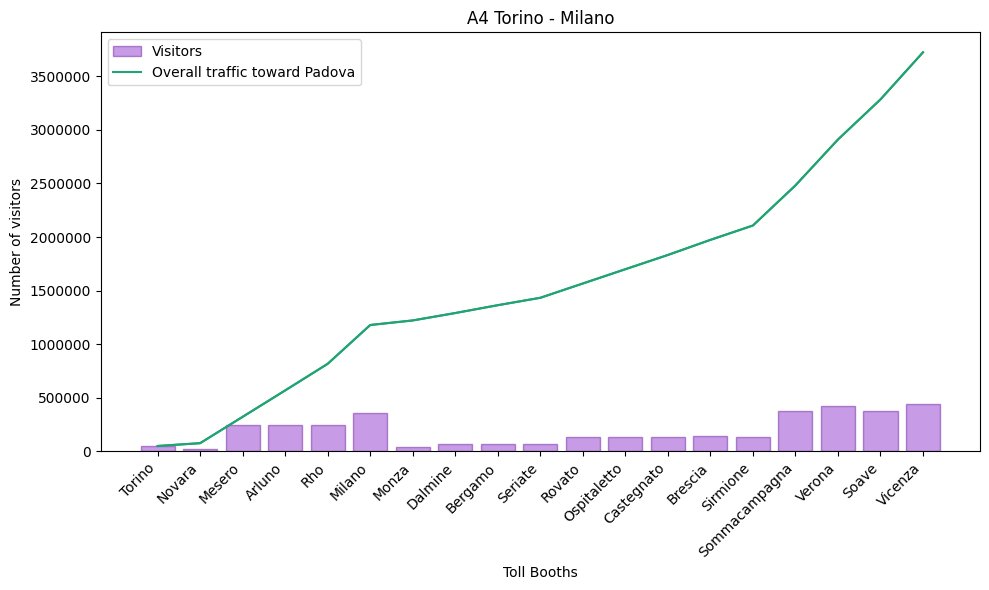

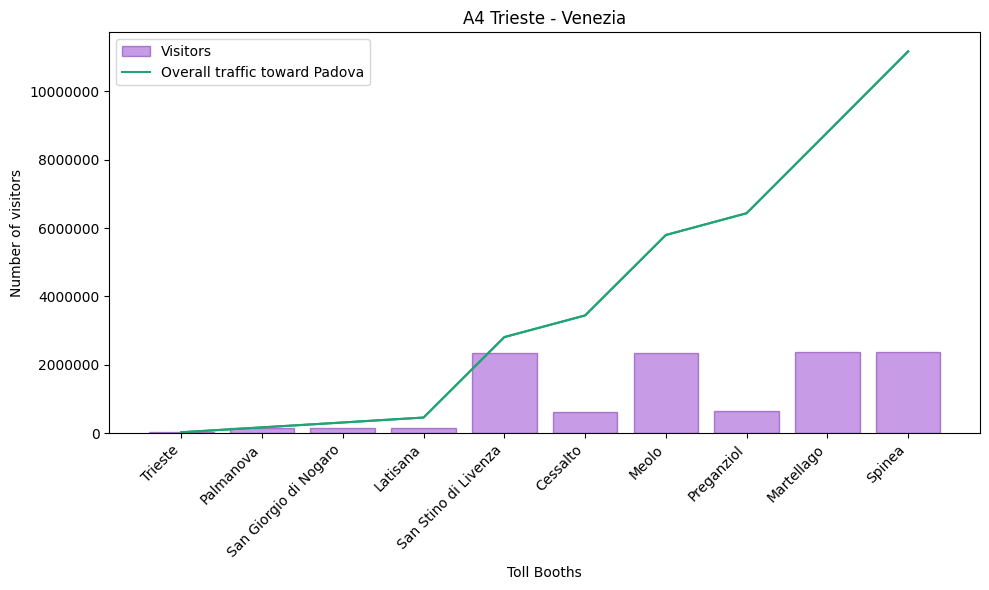

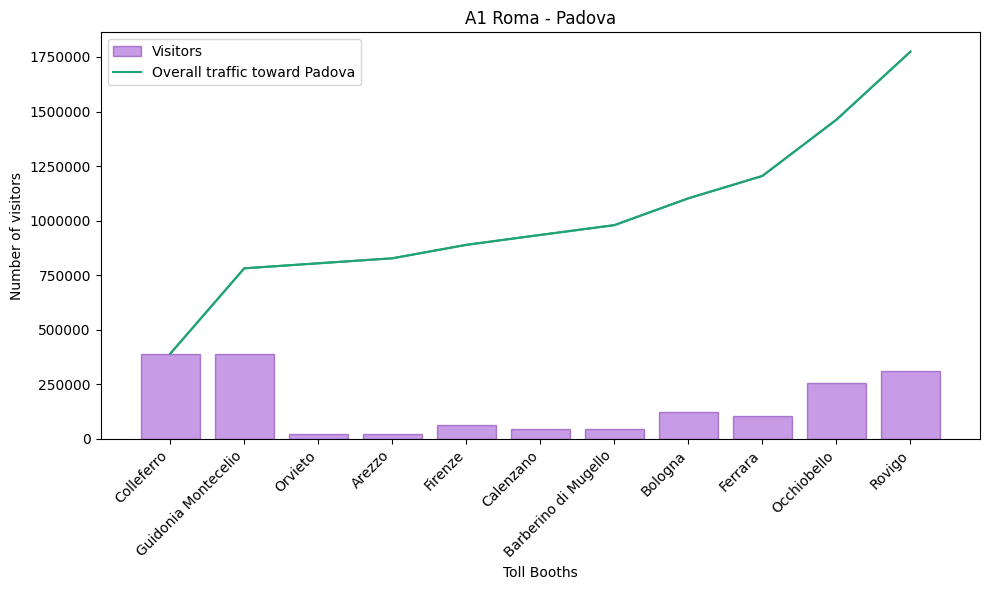

In [15]:
# Plot the graphics
visitors_fluxes()

### 2.1 Mid-range mobility
Mobility to/from nearby regions, which are Lombardia, Trentino Alto Adige, Friuli Venezia Giulia, Emilia Romagna.

##### 2.1.1 Mid-range mobility through highways

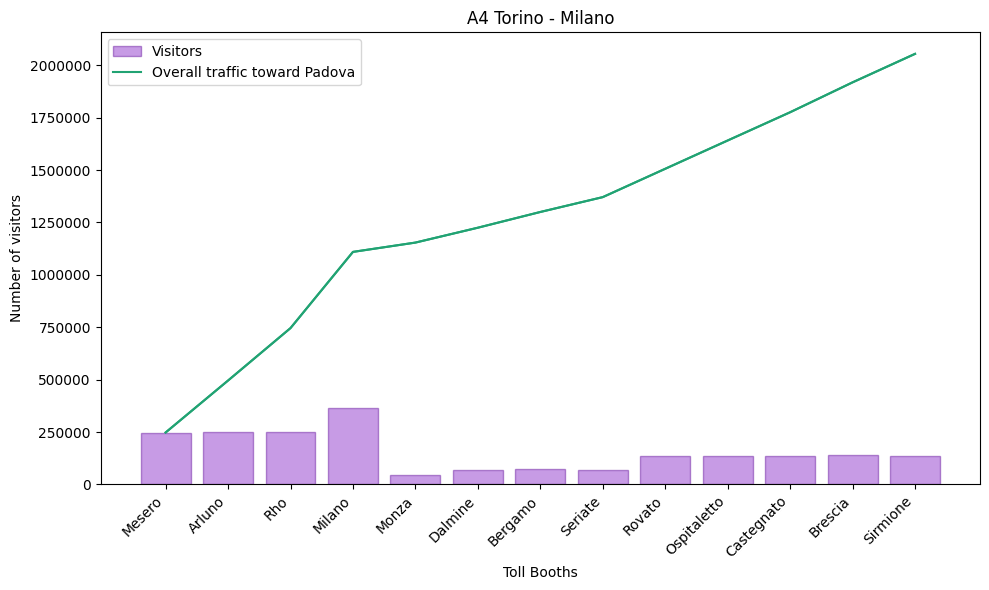

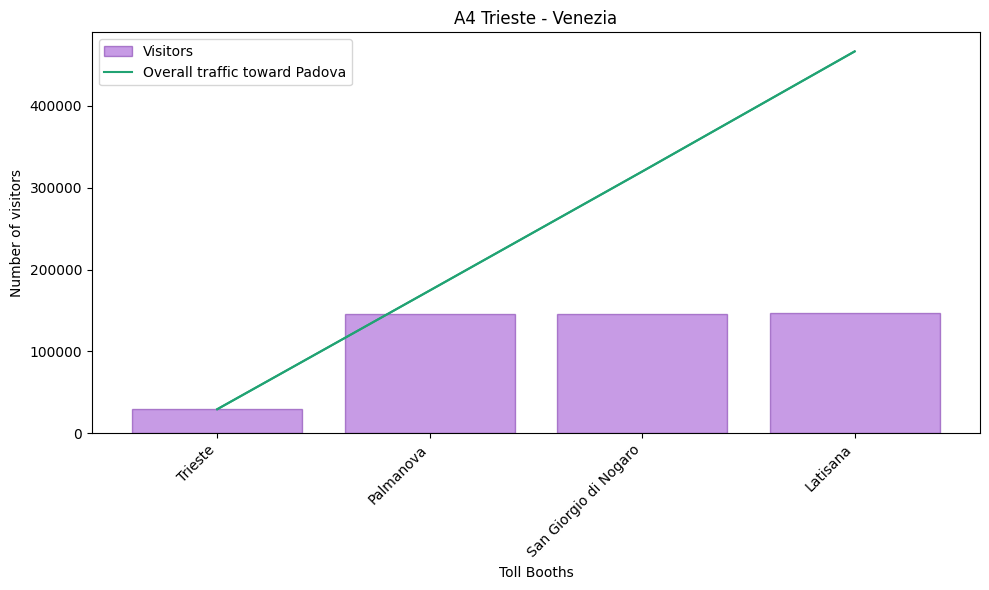

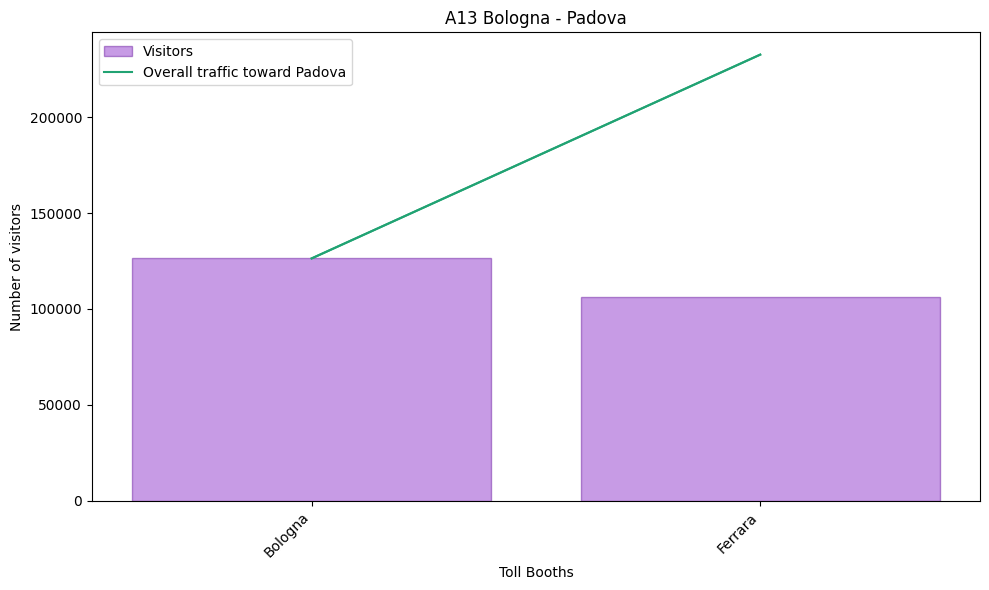

In [16]:
# Through Highways
visitors_fluxes(mid_range=True)

##### 2.1.2 Mid-range mobility through urban-roads
This study does not consider the distance between the provinces and Padua, so the plots are not ordered, they just study the contribution of every province 

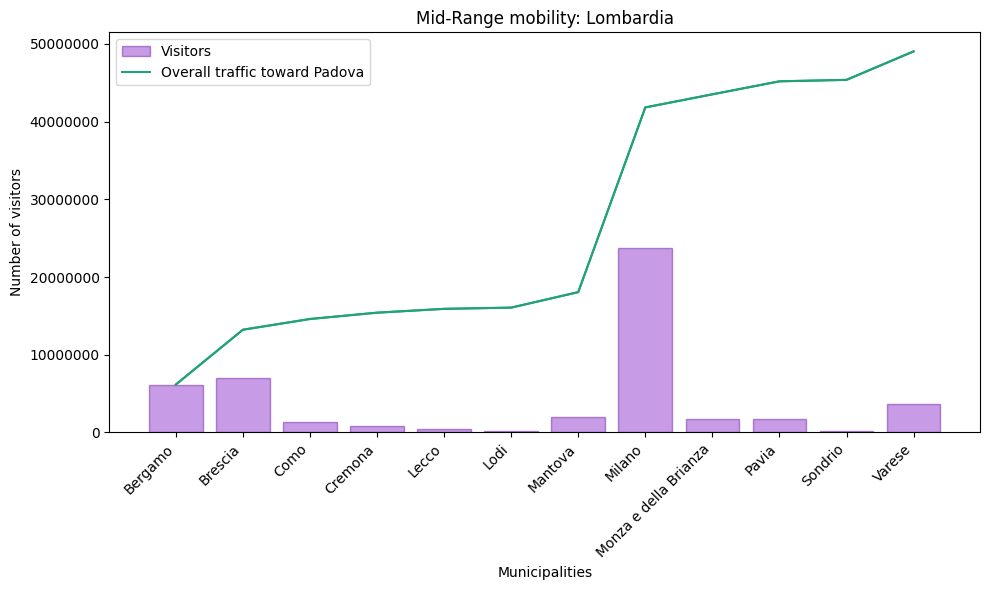

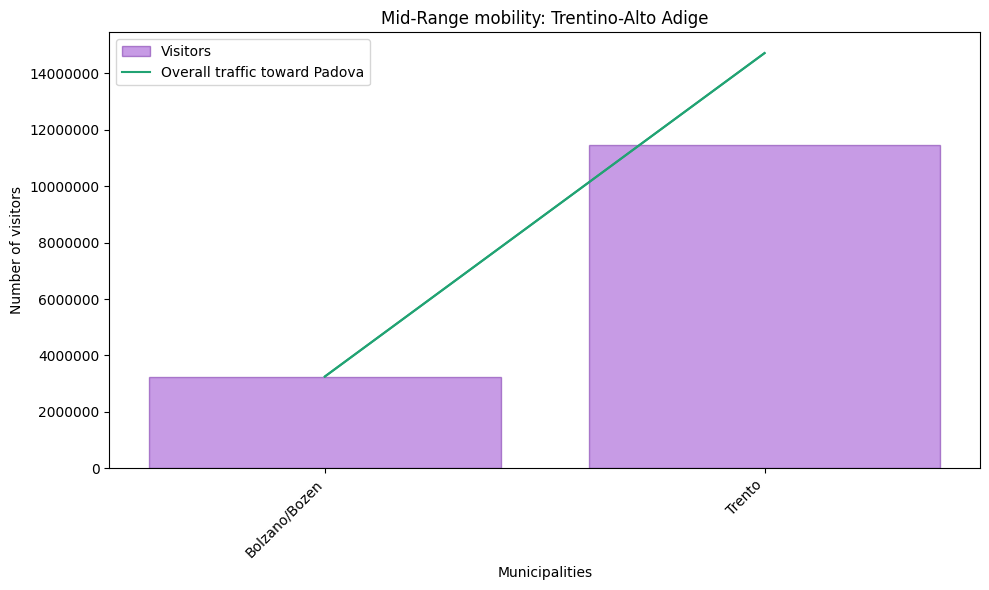

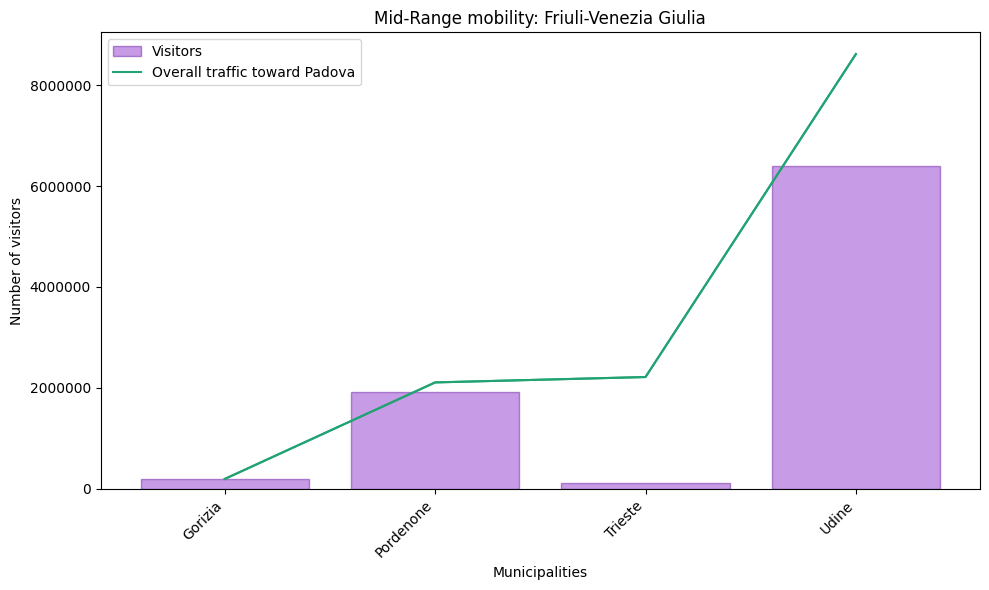

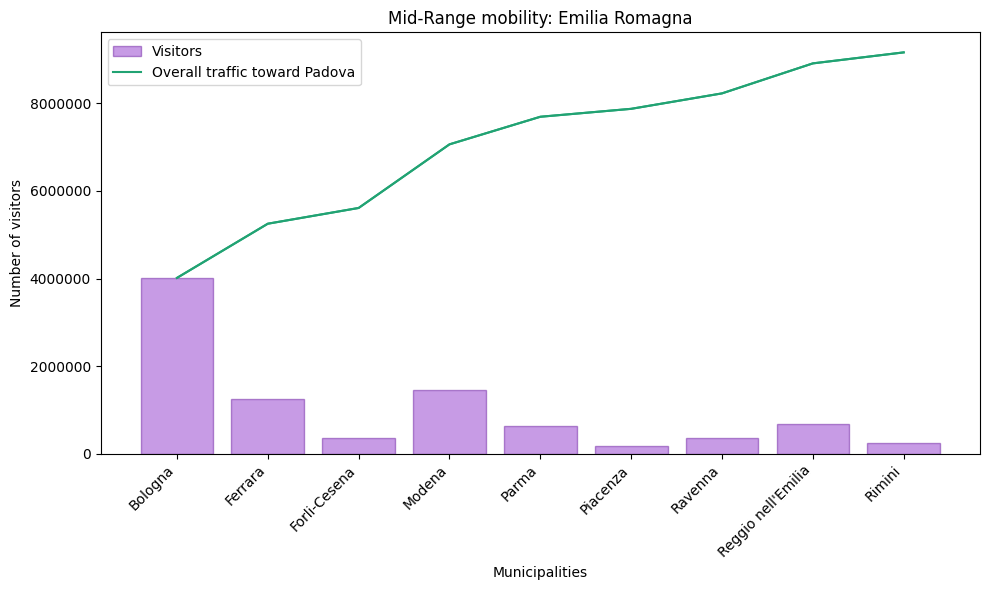

In [17]:
# Through Urban roads
visitors_fluxes(mid_range=True, highway=False)

#### 2.2 Week Flow
Consider the provinces located on the three directions that are mostly contributing to the flow of weekend visitors and working daily commuters

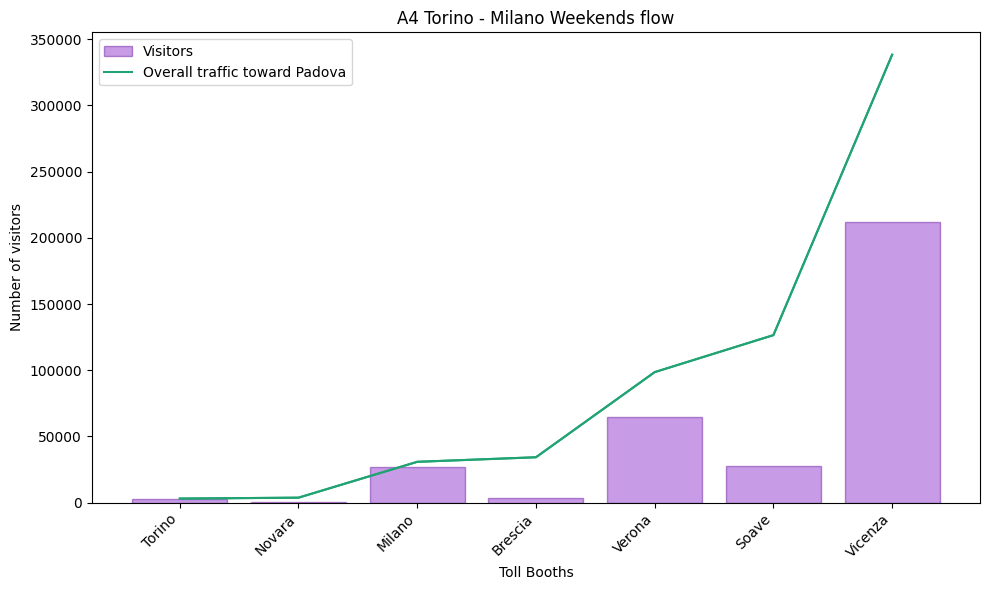

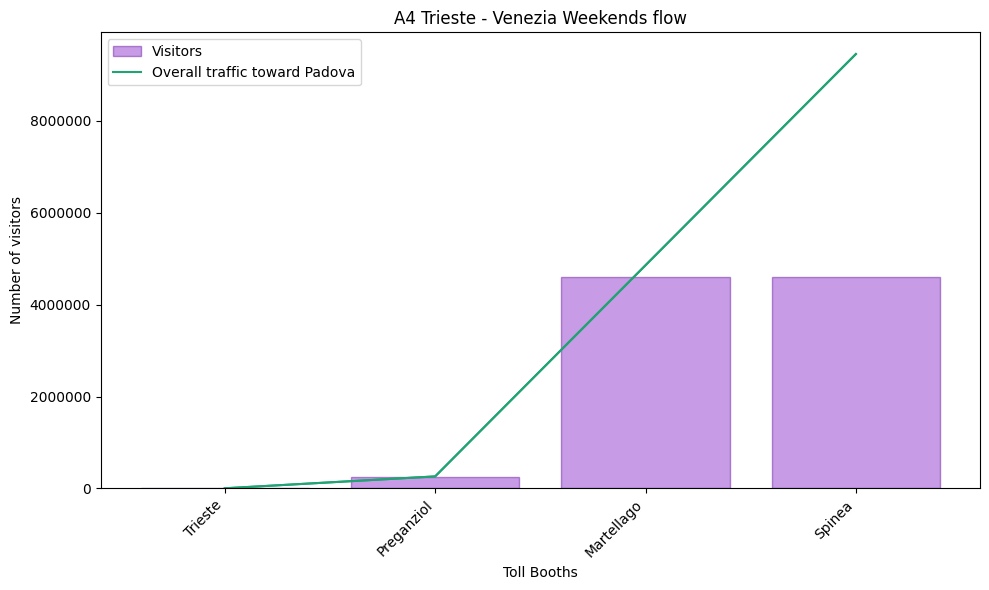

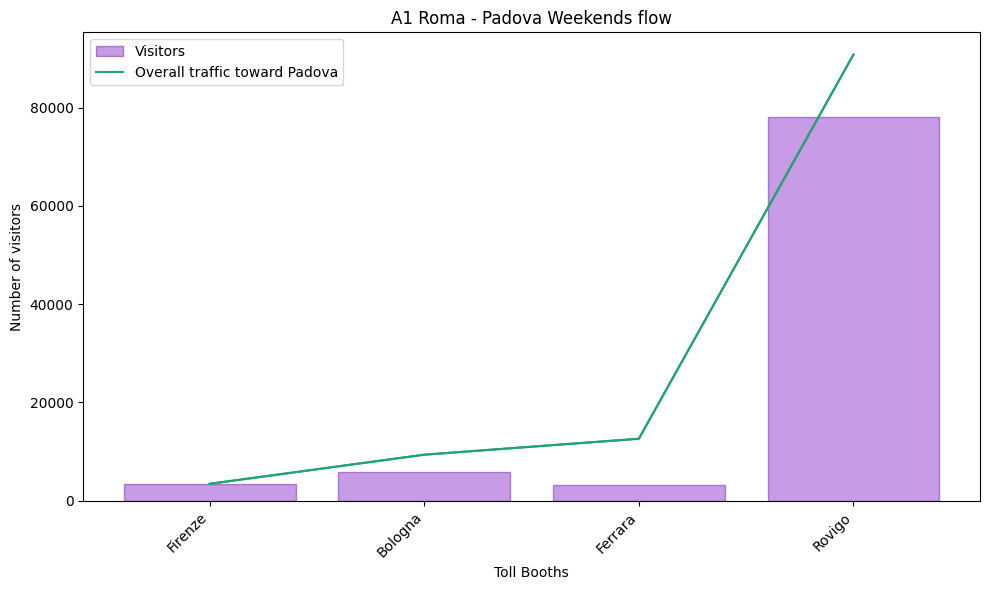

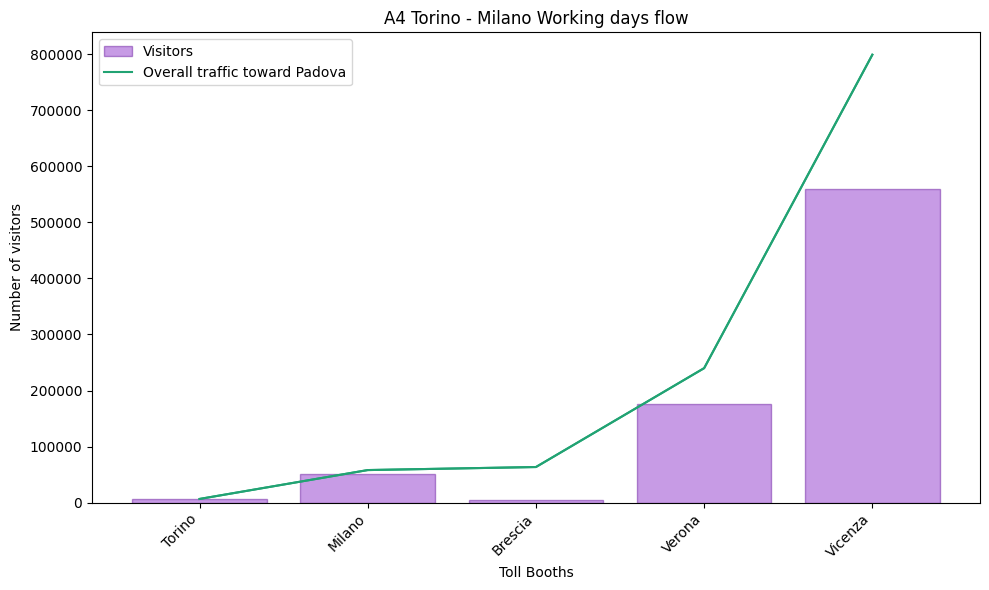

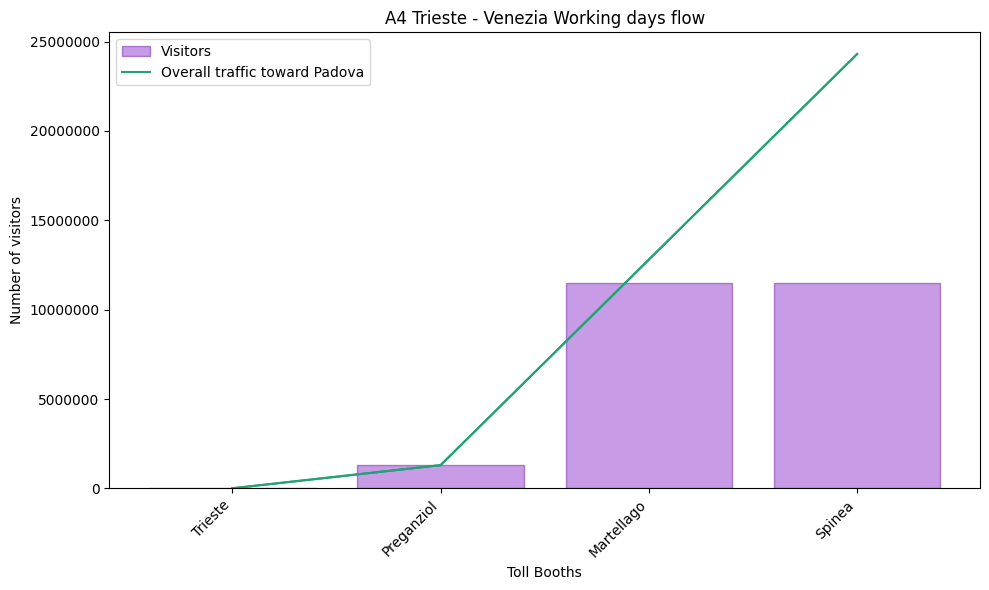

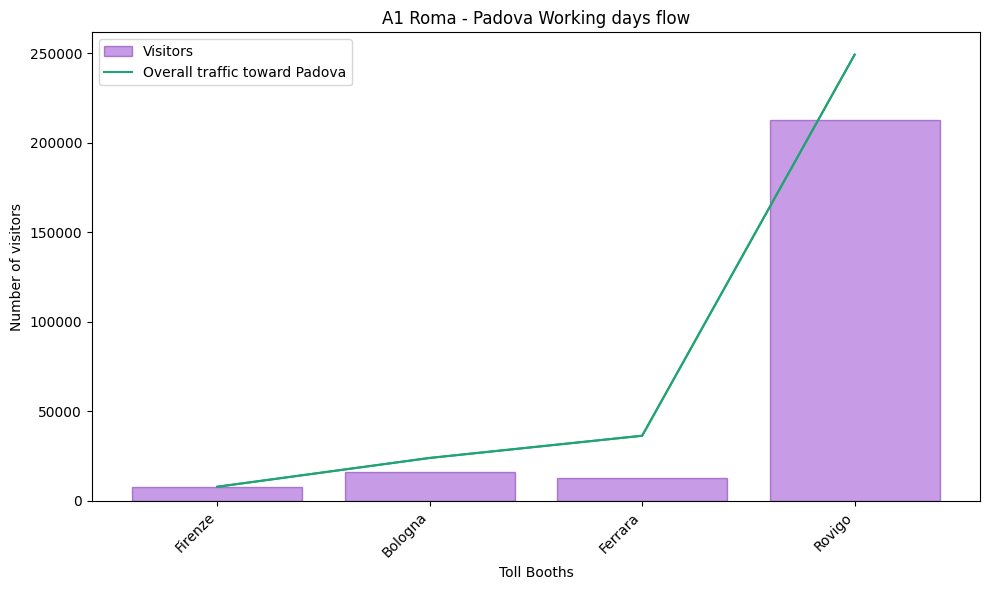

In [18]:
visitors_fluxes(dow_study=True)

# 3 Distribution of the number of visitors by the distance of the province of origin


To better analyze the data we are working with, we first study the distribution of the number of visitors by the distance of the province of origin. In order to do so, we plotted with a scatter plot the distances on the x-axis and the visitors on the y-axis.

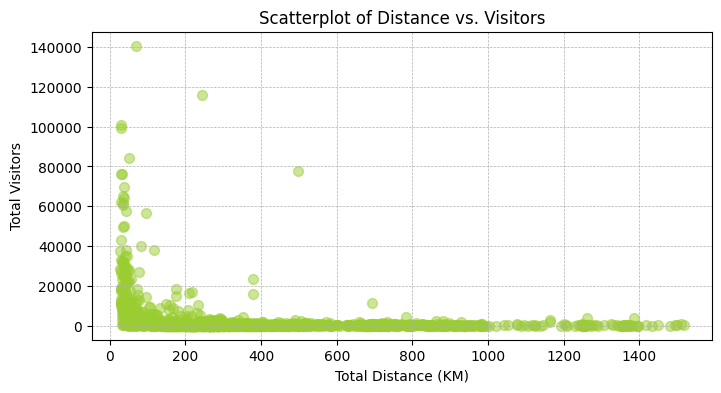

In [19]:
#Upload data
distances_data = pd.read_csv('data/R05_PD.txt', sep="\t", encoding="UTF-8", usecols=['DEST_PROCOM', 'KM_TOT'])

distances_data.rename(columns={'DEST_PROCOM': 'PRO_COM'}, inplace=True)

distances_data['KM_TOT'] = distances_data['KM_TOT'].str.replace(',','.')
distances_data['KM_TOT'] = pd.to_numeric(distances_data['KM_TOT'])

distances_data = distances_data.groupby(['PRO_COM'])[['KM_TOT']].mean()

customers_data = pd.read_csv(filename_distinct_user_day, encoding="latin1", usecols=['PRO_COM','VISITORS'])

# Don't consider Padova
customers_data['PRO_COM'] = np.where(customers_data['PRO_COM'] == 28060.0 , np.nan, customers_data['PRO_COM'])
customers_data.dropna(axis=0, inplace=True)

customers_data = customers_data.groupby(['PRO_COM'])[['VISITORS']].sum()

data = pd.merge(distances_data, customers_data, on='PRO_COM')

data = data.sort_values(['VISITORS'], ascending=False)

# Plot of Distance vs Visitors
plt.figure(figsize=(8, 4)) 
plt.scatter(data['KM_TOT'],data['VISITORS'], color='yellowgreen', alpha=0.5, s=50)
plt.xlabel('Total Distance (KM)')
plt.ylabel('Total Visitors')
plt.title('Scatterplot of Distance vs. Visitors')
plt.grid(True, linestyle='--', linewidth=0.5)  
plt.ticklabel_format(style='plain', axis='y')

plt.show()


A first attempt at model the distribution of visitors by the distances is to use a polynomial fitting function. 
This method can led to overfitting, expecially with a high-degree polynomial such as 5 order, which results in poor generalization to new data. 

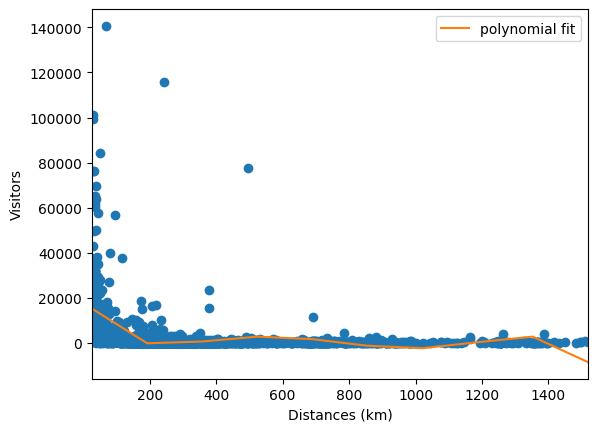

In [20]:
# Assign data
x = data['KM_TOT']
y = data['VISITORS']

# Compute polynomial with order 5
poly = np.polyfit(x, y, 5)
function = np.poly1d(poly)

# Compute new x's and y's
x_new = np.linspace(x.max(), x.min(), 10)
y_new = function(x_new)

plt.plot(x,y,'o')
plt.plot(x_new, y_new, label="polynomial fit")
plt.xlim([x.min()-1, x.max() + 1 ])
plt.xlabel('Distances (km)')  # Etichetta per l'asse x
plt.ylabel('Visitors')  # Etichetta per l'asse y
plt.legend()
plt.show()

Since from the polynomial fitting function didn't led to any interesting results and since the data distribution is too irregular and does not resemble any of the common density function, such as normal, Poisson, geometrical, etc., we tried to use a Kernel Density Estimate (KDE) that provides a rational and visually pleasant representation of the data distribution in order to make some assumptions regarding the law that should be used to describe the distribution.

Below first the distribution of distance and then the distribution of visitors.

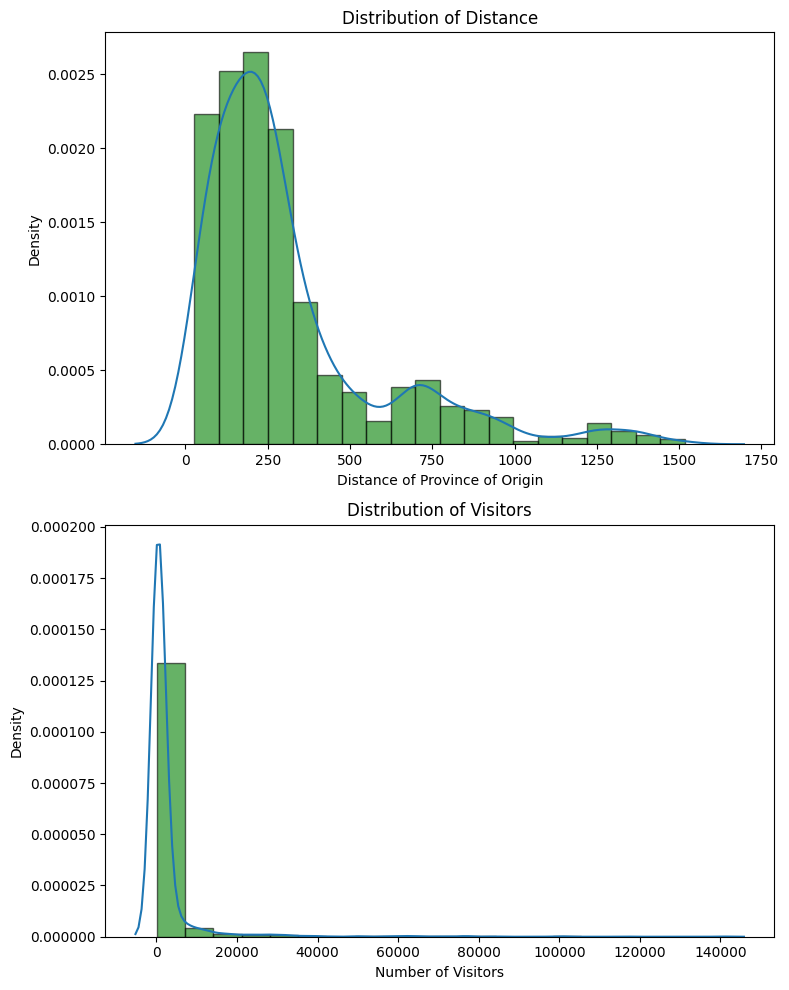

In [21]:
# Create subplot
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot KDE vs histogram for distances 
sns.kdeplot(x, ax=axes[0])
axes[0].set_xlabel('Distance of Province of Origin')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Distance')
axes[0].hist(x, bins=20, density=True, alpha=0.6, color='g', edgecolor='black')

# Plot KDE vs histogram for number of visitors
sns.kdeplot(y, ax=axes[1])
axes[1].set_xlabel('Number of Visitors')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Visitors')
axes[1].hist(y, bins=20, density=True, alpha=0.6, color='g', edgecolor='black')

plt.tight_layout()

plt.show()


From a first visual inspection we can say that both the visitors graph and the distances graph resemble Gaussian functions.

### 3.1 Estimation of the expected number of visitors by the distance of the province of origin

In this section we analyzed various regression techniques tailored to our dataset. 
Initially, we approach our analysis with a Simple Linear Regression approach that did not give satisfactory results, failing to capture the complexities of our data. 
Then, we tried with a more sophisticated method, i.e. Random Forest Regression, in order to obtain grater robustness and flexibility.


**Simple Linear Regression**

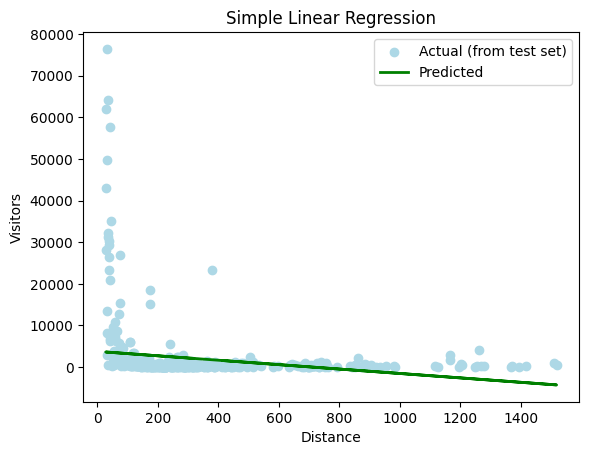

Mean Squared Error: 63122026.03070769


,Actual,Predicted,errors
PRO_COM,,,
28072,76400,3615.451753,72784.548247
28016,64024,3582.919791,60441.080209
28069,61996,3618.693501,58377.306499
29041,57684,3546.547684,54137.452316
28054,49728,3601.064217,46126.935783
...,...,...,...
15118,2388,2361.431007,26.568993
63062,112,91.499330,20.500670
63082,68,49.674009,18.325991


In [22]:
X = np.array(data['KM_TOT']).reshape(-1,1)
y = data['VISITORS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

# Prediction
y_pred = regressor.predict(X_test)

# Plot the results
plt.scatter(X_test, y_test,  color='lightblue', label='Actual (from test set)')
plt.plot(X_test, y_pred, color='green', label='Predicted', linewidth=2)
plt.title('Simple Linear Regression')
plt.xlabel('Distance')
plt.ylabel('Visitors')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Highlight most striking discrepancies
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df['errors'] = abs(y_test - y_pred)

sorted_df = df.sort_values(by='errors', ascending = False)
sorted_df

As expected, the Linear Regression didn't give optimal results, as it can also see from the mean squared error value, very big, and the striking discrepancies highlited by the data frame printed.

**Random Forest Regression**

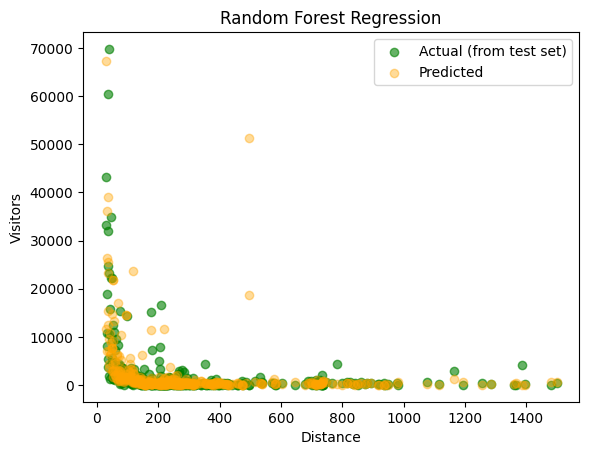

Mean Squared Error: 39249503.33633904


,Actual,Predicted,errors
PRO_COM,,,
28100,69796,9508.44,60287.56
8050,32,51201.76,51169.76
28103,60520,23293.88,37226.12
28105,5432,38977.04,33545.04
28006,8084,36218.24,28134.24
...,...,...,...
16222,104,109.08,5.08
21115,164,160.96,3.04
13238,116,118.48,2.48


In [23]:
X = np.array(data['KM_TOT']).reshape(-1,1)
y = data['VISITORS'] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Prediction
y_pred = rf_regressor.predict(X_test)

# Plot results
plt.scatter(X_test, y_test, color='green', label='Actual (from test set)', alpha=0.6)
plt.scatter(X_test, y_pred, color='orange', label='Predicted', alpha=0.4)
plt.xlabel('Distance')
plt.ylabel('Visitors')
plt.title('Random Forest Regression')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Highlight most striking discrepancies
dff = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dff['errors'] = abs(y_test - y_pred)

sorted_dff = dff.sort_values(by='errors', ascending = False)
sorted_dff

In this specific case, the use of Machine Learning model seems to be the best choice given that we don't have linear relationships between predictors and the target variable. 